## **Notebook Summary**

### **Purpose**
This notebook evaluates and visualizes the performance of a clinical trial-patient matching system ("trial_matches.json"), comparing system-assigned trial suitability verdicts against curated gold-standard labels.

---

### **Key Steps and Logic**

#### **1. Data Loading**
- Loads:
  - **Gold/reference** patient-trial pairs and scores from `test.tsv`.
  - **Patient queries** and **trial corpus** from `queries.jsonl` and `corpus.jsonl`.
  - **Trial matches** (detailed matching outputs) from `matched/trial_matches.json` (contains verdicts, reasoning about inclusion/exclusion).

#### **2. Flatten & Normalize Trial Matches**
- Iterates through `trial_matches.json` to **flatten nested structures** into a DataFrame:
  - Columns include: `query-id`, `corpus-id`, model trial verdict (`match_verdict`), reasoning, inclusion/exclusion flags, and detailed eligibility explanations.

#### **3. Merge Gold with System Predictions**
- Merges gold-standard pairs (`df_tsv`) with matched verdicts (`df_trial_matches`) by query and trial IDs.
- Ensures **all gold pairs are present**, filling unmatched ones with NaN for later filtering/checks.

#### **4. Label Harmonization**
- Maps system verdicts (“STRONG MATCH”, “POSSIBLE MATCH”, “WEAK MATCH”, “UNSUITABLE”) into numeric label space {0, 1, 2} for comparison:
  - 2: Highly likely ("STRONG MATCH" or "POSSIBLE MATCH")
  - 1: Would consider ("WEAK MATCH")
  - 0: Would not refer ("UNSUITABLE")
- Aligns ground-truth labels from gold file into the same space.

#### **5. Evaluation**
- **Omissions:** Reports count/samples of pairs where there is no system verdict (excluded from scoring).
- **Metrics:**
  - Computes **confusion matrix** (tabular and heatmap) to visualize agreement.
  - Calculates **macro-averaged F1 score** and displays a full classification report (precision/recall per label).
- **Visualization:** Plots the confusion matrix with Seaborn for a clear model performance summary.

#### **6. Inspection & Quality Control**
- Provides options to display merged/evaluated DataFrame (with explanations/reasoning), as well as any omitted/missing rows.

#### **7. Display/Output**
- Configures pandas for wide displays, allowing direct inspection of large slices of merged data and reasoning fields.

---

### **Outputs**
- **Metrics for Model QA:** Confusion matrix, macro F1, precision/recall for each decision level.
- **Visualization:** Color-coded confusion matrix heatmap for rapid error pattern assessment.
- **Inspection:** Full merged DataFrame can be displayed, supporting qualitative analysis via system reasoning and verdicts.

---

### **Intended Use**
- **Model validation and debugging:** Evaluate system-patient-to-trial assignment quality.
- **Insight into errors:** Directly reveals misclassifications and their reasoning by exploring DataFrame rows.
- **Transparent reporting:** Well-suited for sharing system strengths and weaknesses with stakeholders or during clinical IR system development.

---

### **Technical/Architectural Notes**
- **Robust merging:** Ensures all reference pairs are considered, not just those found by the matcher.
- **Extendable:** Can be easily fit for other datasets or more granular scoring/justification analysis.
- **User-friendly:** Designed for rapid exploratory analysis, including straightforward displays for both summary and raw data.

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
# Set pandas display options 
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 400)

In [3]:
import os
import pandas as pd
import json

# Set up paths
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load main input data
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

In [4]:
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

 df_tsv 3870 df_queries 59 df_corpus 3626


In [5]:
# Glimpse at dataframes:
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())
# display(trial_matches_long.head())

# ---- Now you can proceed with analysis & evaluation below!

,query-id,corpus-id,score
0,sigir-20141,NCT00000408,0
1,sigir-20141,NCT00000492,1
2,sigir-20141,NCT00000501,0
3,sigir-20141,NCT00001853,0
4,sigir-20141,NCT00004727,0


,_id,text
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is not increased on inspiration. The latest episode of pain ended half an hour prior to her arrival. Sh..."
1,sigir-20142,"An 8-year-old male presents in March to the ER with fever up to 39 C, dyspnea and cough for 2 days. He has just returned from a 5 day vacation in Colorado. Parents report that prior to the onset of fever and cough, he had loose stools. He denies upper respiratory tract symptoms. On examination he is in respiratory distress and has bronchial respiratory sounds on the left. A chest x-ray shows b..."
2,sigir-20143,"A 58-year-old nonsmoker white female with mild exertional dyspnea and occasional cough is found to have a left lung mass on chest x-ray. She is otherwise asymptomatic. A neurologic examination is unremarkable, but a CT scan of the head shows a solitary mass in the right frontal lobe."
3,sigir-20144,"A 2-year-old boy is brought to the emergency department by his parents for 5 days of high fever and irritability. The physical exam reveals conjunctivitis, strawberry tongue, inflammation of the hands and feet, desquamation of the skin of the fingers and toes, and cervical lymphadenopathy with the smallest node at 1.5 cm. The abdominal exam demonstrates tenderness and enlarged liver. Laborator..."
4,sigir-20145,A 56-year-old female on 20th day post-left mastectomy presents to the emergency department complaining of shortness of breath and malaise. The patient says that she has remained in bed for the last two weeks. The physical examination reveals tenderness on the left upper thoracic wall and right calf. The surgical incision shows no bleeding or signs of infection. Pulmonary auscultation is signif...


,_id,title,metadata
0,NCT00000369,Maintenance Therapies in Bipolar Disorders,"{'phase': 'Phase 3', 'drugs': '['Individual psychotherapy', 'Lithium carbonate']', 'drugs_list': ['Individual psychotherapy', 'Lithium carbonate'], 'diseases_list': ['Bipolar Disorder'], 'enrollment': '0', 'inclusion_criteria': 'Patients must have: Acute bipolar I illness and be experiencing a manic or depressed episode at the time of study entry. Required: Current treatment with lithium carbo..."
1,NCT00000402,Calcium and Bone Mass in Young Females,"{'phase': 'Phase 2', 'drugs': '['Calcium']', 'drugs_list': ['Calcium'], 'diseases_list': ['Osteoporosis'], 'enrollment': '354', 'inclusion_criteria': '- Pubertal stage II - Calcium intake below a threshold level - Caucasian - Normal health', 'exclusion_criteria': '- Medications affecting calcium and bone metabolism - Chronic diseases - Metabolic bone disease - Abnormality in calcium metabolism..."
2,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education evaluation'], 'diseases_list': ['Low Back Pain'], 'enrollment': '580', 'inclusion_criteria': '- Must live in the United States - Must understand and write English - Must have access to a computer with e-mail and expect to have this access for at least 3 years - Must be 18 years old - Must have seen ..."
3,NCT00000430,Low-Dose Hormone Replacement Therapy and Alendronate for Osteoporosis,"{'phase': 'Phase 3', 'drugs': '['Alendronate', 'Estrogen/progestin therapy']', 'drugs_list': ['Alendronate', 'Estrogen/progestin therapy'], 'diseases_list': ['Osteopenia', 'Osteoporosis'], 'enrollment': '240', 'inclusion_criteria': '- Women at least 60 years of age. - Good general health. - Willingness to participate in this 3.5 year study. - Ability to give informed consent. - Ability to live..."
4,NCT00000432,Lyme Disease Prevention Program,"{'phase': 'Phase 3', 'drugs': '['Education about disease prevention']', 'drugs_list': ['Education about disease prevention'], 'diseases_list': ['Lyme Disease', 'Tick-Borne Diseases'], 'enrollment': '20000', 'inclusion_criteria': '- Ferry passengers traveling to Nantucket Island', 'exclusion_criteria': '- Foreign (non-U.S.) residence', 'brief_summary': 'This is a large study of an educational p..."


In [6]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the JSON as a list of dicts
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flattening loop
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Create DataFrame
df_trial_matches = pd.DataFrame(records)

# Preview
pd.set_option('display.max_colwidth', 200)
display(df_trial_matches.head())

,query-id,corpus-id,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning
0,sigir-20141,NCT01724996,Usefulness of Chest Wall Tenderness as Bedside Test to Exclude Acute Coronary Syndrome in Different Demographic Groups,6,WOULD CONSIDER REFERRAL,"The patient presents with episodic pressing/burning anterior chest pain, which aligns with the trial's focus on chest pain. The trial aims to evaluate the usefulness of chest wall tenderness as a ...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified
1,sigir-20141,NCT00001853,Diabetes and Heart Disease Risk in Blacks,6,WOULD CONSIDER REFERRAL,"The patient's profile shows some alignment with the trial requirements, but there are also uncertainties and missing information. The patient is a 58-year-old African-American woman, which matches...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified
2,sigir-20141,NCT00005485,Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans,9,HIGHLY LIKELY TO REFER,"The patient is a 58-year-old African-American woman with a chief complaint of episodic pressing/burning anterior chest pain, which is suggestive of cardiovascular disease. Her medical history of h...",PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient's demographics indicate she is an African-American woman, which meets the trial's inclusion criterion of being African American."
3,sigir-20141,NCT00074880,The Role of Heart Stiff and Weak Atrium on Exercise Capacity in Patients With Hypertrophic Cardiomyopathy,2,WOULD NOT REFER,"The patient's profile does not align with the trial requirements for several key reasons. Firstly, the trial is focused on patients with hypertrophic cardiomyopathy (HCM), but the patient's diagno...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified
4,sigir-20141,NCT00005123,Honolulu Heart Program,2,WOULD NOT REFER,"The patient's profile does not align with the trial requirements for several key reasons. Firstly, the Honolulu Heart Program specifically focuses on American men of Japanese ancestry, whereas the...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified


In [7]:
df_trial_matches

,query-id,corpus-id,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning
0,sigir-20141,NCT01724996,Usefulness of Chest Wall Tenderness as Bedside Test to Exclude Acute Coronary Syndrome in Different Demographic Groups,6,WOULD CONSIDER REFERRAL,"The patient presents with episodic pressing/burning anterior chest pain, which aligns with the trial's focus on chest pain. The trial aims to evaluate the usefulness of chest wall tenderness as a ...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified
1,sigir-20141,NCT00001853,Diabetes and Heart Disease Risk in Blacks,6,WOULD CONSIDER REFERRAL,"The patient's profile shows some alignment with the trial requirements, but there are also uncertainties and missing information. The patient is a 58-year-old African-American woman, which matches...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified
...,...,...,...,...,...,...,...,...,...,...,...,...
7550,sigir-201530,NCT00462241,"Treatment Study Comparing Manual Treatment or Advice in Acute, Musculoskeletal Chest Pain",None,None,None,EXCLUDE,"The patient's pain is not related to the joints and muscles of the neck and/or thorax, as the chief complaint and key findings indicate pain, bruising, swelling, and dislocation of the elbow, whic...",None,None,None,None
7551,sigir-201530,NCT00847236,Protocol For The Quantitation Of Pain In The Diagnosis Of Polymyalgia Rheumatica,None,None,None,EXCLUDE,"The patient is less than 50 years old, specifically 47 years old, which meets the exclusion criterion of ""Patients less than 50 years old"".",None,None,None,None


In [8]:
df_trial_matches[(df_trial_matches["match_verdict"].isna())]

,query-id,corpus-id,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning
7,sigir-20141,NCT01936909,Interleukin-1 Blockade in Recently Decompensated Heart Failure,None,None,None,PASS,No exclusion criteria specified,FAIL,None,1. Primary diagnosis for hospitalization is decompensated heart failure\n2. Prior documentation of impaired left ventricular systolic function\n3. Patient is now clinically stable and meets standa...,"The patient's chief complaint is episodic chest pain, which suggests a possible diagnosis of acute coronary syndrome, rather than decompensated heart failure. Additionally, there is no mention of ..."
11,sigir-20141,NCT02585076,A Cross-sectional Study for the Determination of the Prevalence of Non-valvular Atrial Fibrillation Among Patients Diagnosed With Hypertension,None,None,None,PASS,No exclusion criteria specified,FAIL,None,- Female and male outpatients aged 60 years and older (patient is 58 years old),"The patient summary indicates the patient is 58 years old, which does not meet the inclusion criterion of being 60 years or older. Although the patient has hypertension and other criteria could po..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7550,sigir-201530,NCT00462241,"Treatment Study Comparing Manual Treatment or Advice in Acute, Musculoskeletal Chest Pain",None,None,None,EXCLUDE,"The patient's pain is not related to the joints and muscles of the neck and/or thorax, as the chief complaint and key findings indicate pain, bruising, swelling, and dislocation of the elbow, whic...",None,None,None,None
7551,sigir-201530,NCT00847236,Protocol For The Quantitation Of Pain In The Diagnosis Of Polymyalgia Rheumatica,None,None,None,EXCLUDE,"The patient is less than 50 years old, specifically 47 years old, which meets the exclusion criterion of ""Patients less than 50 years old"".",None,None,None,None


In [9]:
df_trial_matches['score'] = df_trial_matches['score'].fillna(0)
df_trial_matches['match_verdict'] = df_trial_matches['match_verdict'].fillna("WOULD NOT REFER")

In [10]:
len(df_trial_matches)

7552

In [11]:
# df_tsv: gold/reference pairs
# df_trial_matches: detailed match+reasoning info from trial_matches.json

# Merge, keeping all gold standard pairs and including trial_matches info when available:
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

Rows with missing match_verdict (excluded from evaluation): 1914

Confusion matrix (table):



,0) WOULD NOT REFER,1) WOULD CONSIDER REFERRAL,2) HIGHLY LIKELY TO REFER
0) WOULD NOT REFER,949,174,35
1) WOULD CONSIDER REFERRAL,190,243,44
2) HIGHLY LIKELY TO REFER,75,150,96



Macro F1 score: 0.5509

Detailed classification report:

                            precision    recall  f1-score   support

        0) WOULD NOT REFER       0.78      0.82      0.80      1158
1) WOULD CONSIDER REFERRAL       0.43      0.51      0.47       477
 2) HIGHLY LIKELY TO REFER       0.55      0.30      0.39       321

                  accuracy                           0.66      1956
                 macro avg       0.59      0.54      0.55      1956
              weighted avg       0.66      0.66      0.65      1956



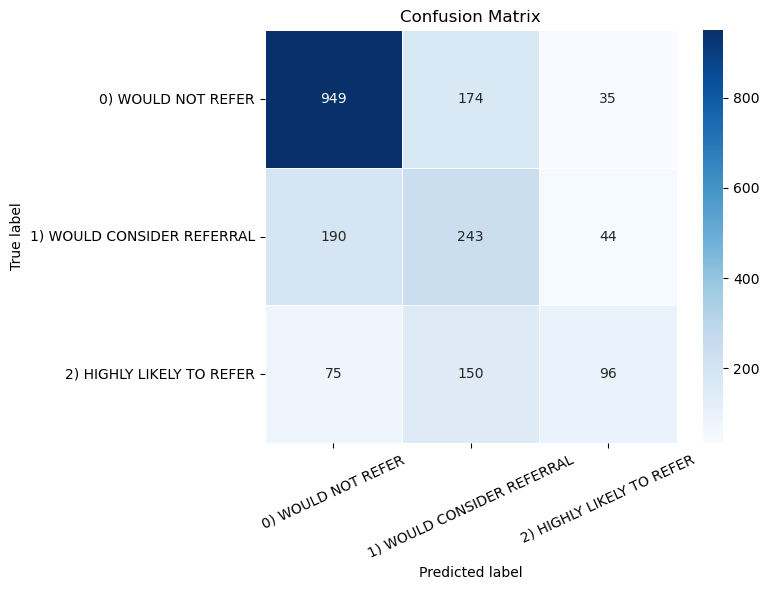


Sample of omitted rows (no match_verdict):


,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
0,sigir-20141,NCT00000408,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,sigir-20141,NCT00000492,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,sigir-20141,NCT00004727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,sigir-20141,NCT00005127,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
7,sigir-20141,NCT00005757,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd

verdict_map = {
    "HIGHLY LIKELY TO REFER": 2,
    "WOULD CONSIDER REFERRAL": 1,
    "WOULD NOT REFER": 0,
    "None": 0,
}

merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map)#.fillna(0).astype(int)
merged_df['true_label'] = merged_df['score_x']

labels = [0, 1, 2]
label_names = [
    "0) WOULD NOT REFER",
    "1) WOULD CONSIDER REFERRAL",
    "2) HIGHLY LIKELY TO REFER"
]

n_missing = merged_df['match_verdict'].isna().sum()
print(f"Rows with missing match_verdict (excluded from evaluation): {n_missing}")

eval_df = merged_df[~merged_df['predicted_label'].isna() & ~merged_df['true_label'].isna()]
y_true = eval_df['true_label'].astype(int)
y_pred = eval_df['predicted_label'].astype(int)

cm = confusion_matrix(y_true, y_pred, labels=labels)
f1 = f1_score(y_true, y_pred, labels=labels, average='macro')

print("\nConfusion matrix (table):\n")
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
display(cm_df)

print("\nMacro F1 score: {:.4f}".format(f1))
print("\nDetailed classification report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=label_names))

# Blue Confusion Matrix Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# Show omitted rows if any
if n_missing > 0:
    print("\nSample of omitted rows (no match_verdict):")
    display(merged_df[merged_df['match_verdict'].isna()].head())

In [13]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
6,sigir-20141,NCT00005485,2,Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans,9,HIGHLY LIKELY TO REFER,"The patient is a 58-year-old African-American woman with a chief complaint of episodic pressing/burning anterior chest pain, which is suggestive of cardiovascular disease. Her medical history of h...",PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient's demographics indicate she is an African-American woman, which meets the trial's inclusion criterion of being African American.",2.0,2
172,sigir-201410,NCT01599195,2,Use of Amplified Sound Signal to Identify Presence of Carotid and Femoral Stenosis,9,HIGHLY LIKELY TO REFER,"The patient presents with a strong match for the trial requirements due to several key factors. Firstly, the patient's age of 67 falls within the specified range of 19-90 years, meeting the inclus...",PASS,Patient does not meet any exclusion criteria,INCLUDE,None,None,"The patient is 67 years old, which falls within the 19-90 years age range. Additionally, the patient has a history of undergoing cardiac catheterization via the right femoral artery and presents w...",2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627,sigir-20156,NCT01182584,2,Application of Digital Infrared Thermal Imaging (DITI) in Graves' Disease,9,HIGHLY LIKELY TO REFER,"The patient's symptoms, such as weight loss, sweating, insomnia, diarrhea, increased appetite, heart racing, irregular pulse, warm and sweaty hands, hyperreflexia, and mild exophthalmia, are highl...",PASS,Patient does not meet any exclusion criteria,INCLUDE,None,None,"The patient's symptoms, such as weight loss, sweating, insomnia, diarrhea, increased appetite, heart racing, irregular pulse, warm and sweaty hands, hyperreflexia, and mild exophthalmia, are consi...",2.0,2
3666,sigir-20156,NCT02210741,2,Next-generation Sequencing (NGS) of Peripheral Blood Immune Repertoire in Graves' Disease,8,HIGHLY LIKELY TO REFER,"The patient's symptoms, such as weight loss, sweating, insomnia, diarrhea, increased appetite, and heart racing, along with the physical examination findings of warm and sweaty hands, hyperreflexi...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified,2.0,2


Rows: 96


In [14]:
# Cell 2: True label 1, prediction available
df_true1_pred = merged_df[(merged_df["score_x"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
48,sigir-20141,NCT00797953,1,Phase II Multi-Center Study of T89 to Treat Chronic Stable Angina,6,WOULD CONSIDER REFERRAL,"The patient's chief complaint of episodic pressing/burning anterior chest pain, accompanied by nausea, diaphoresis, and mild dyspnea, suggests a potential diagnosis of angina pectoris, which align...",PASS,Patient does not meet any exclusion criteria,UNDETERMINED,- Pregnancy test results\n- Menstrual status and method of contraception\n- Detailed medical history of coronary artery disease\n- Symptoms and diagnosis of chronic angina\n- Exercise tolerance te...,None,"The patient summary does not provide sufficient information to determine if the patient meets all the inclusion criteria. While the patient's age and chief complaint suggest potential eligibility,...",1.0,1
50,sigir-20141,NCT00808652,1,Prevalence and Outcome of Brachial Artery Endothelial Function in Morbidly Obese Patients Undergoing Bariatric Surgery,6,WOULD CONSIDER REFERRAL,"The patient's profile indicates a history of obesity, which aligns with the trial's focus on morbidly obese patients. However, the patient's summary lacks specific details on their obesity level, ...",PASS,Insufficient evidence to confirm any exclusion criteria,UNDETERMINED,"- Specific details on the patient's obesity level (e.g., BMI) and whether it meets the NIH criteria for surgical intervention",None,"The patient summary mentions ""obesity"" in the medical history, but it does not provide specific information on the patient's BMI or whether the obesity meets the NIH criteria for surgical interven...",1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,sigir-20158,NCT02447614,1,Follow-up Studies of Primary Snoring(PS) and Obstructive Sleep Apnea Hypopnea Syndrome(OSAHS) in Chinese Children,6,WOULD CONSIDER REFERRAL,"The patient's age of 10 years meets the trial's age criterion, and the chief complaint of nighttime snoring aligns with the trial's focus on primary snoring and obstructive sleep apnea hypopnea sy...",PASS,Insufficient evidence to confirm any exclusion criteria,UNDETERMINED,- Referral for clinical evaluation of habitual snoring\n- Scheduled for an overnight polysomnogram,None,"The patient's age (10 years old) meets the age criterion. However, there is no information in the patient summary indicating that the patient was referred for clinical evaluation of habitual snori...",1.0,1
3816,sigir-20158,NCT02562040,1,Pediatric Adenotonsillectomy for Snoring,6,WOULD CONSIDER REFERRAL,"The patient's chief complaint of nighttime snoring, pauses in breathing, restlessness, nighttime awakenings, declining grades, lack of attention, and excessive sleepiness during class aligns with ...",PASS,Insufficient evidence to confirm any exclusion criteria.,UNDETERMINED,- Obstructive apnea index (OAI)\n- Apnea-hypopnea index (AHI)\n- Nocturnal polysomnography results\n- Tonsillar hypertrophy assessment\n- Otolaryngologist evaluation for adenotonsillectomy,None,"The patient summary lacks crucial information to determine eligibility for the trial, including specific sleep disorder metrics (OAI, AHI), nocturnal polysomnography results, tonsillar hypertrophy...",1.0,1


Rows: 243


In [15]:
# Cell 3: True label 0, prediction available
df_true0_pred = merged_df[(merged_df["score_x"] == 0) & (merged_df["predicted_label"] == 0)]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
17,sigir-20141,NCT00166231,0,Understanding Pediatric Chest Pain and Other Symptoms,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria,FAIL,None,- 8-18 years of age (patient is 58 years old)\n- English speaking (language not specified),"The patient's age (58 years old) does not meet the inclusion criterion of 8-18 years of age. Additionally, there is no information provided about the patient's language, which is another required ...",0.0,0
34,sigir-20141,NCT00462241,0,"Treatment Study Comparing Manual Treatment or Advice in Acute, Musculoskeletal Chest Pain",0,WOULD NOT REFER,None,EXCLUDE,"The patient's chief complaint of ""episodic pressing/burning anterior chest pain"" that ""radiates to the back"" suggests pain not related to the joints and muscles of the neck and/or thorax, meeting ...",None,None,None,None,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,sigir-20159,NCT02258763,0,Trial on the Ideal Duration of Oral Antibiotics in Children With Pneumonia,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria,FAIL,None,"- Age (patient is 10 years old, but the trial includes children from 3 months to 59 months old)\n- Duration of symptoms (patient had a viral illness two weeks ago, but it's unclear if the current ...","The patient's age exceeds the specified range for the trial, and there is insufficient information to confirm other key criteria such as duration of symptoms, response to IV antibiotics, and chest...",0.0,0
3865,sigir-20159,NCT02459171,0,Household Transmission of Zoonotic Influenza Viruses in a Cohort of Egyptian Poultry Growers,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria,FAIL,None,- Poultry-exposed individuals with poultry in the household,"The patient summary does not indicate exposure to poultry, but rather a recent stay with relatives on a farm that raises domestic pigs, which does not meet the trial's inclusion criteria of having...",0.0,0


Rows: 949


In [16]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Only use rows with non-missing score_y and score_x
yx = merged_df.loc[(~merged_df['score_y'].isna()) & (~merged_df['score_x'].isna()), ['score_y', 'score_x']]
score_y = yx['score_y'].values.astype(int)  # model output
score_x = yx['score_x'].values.astype(int)  # true labels

results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        preds = np.digitize(score_y, bins=[cut1, cut2])  # (0, 1, 2)
        macro_f1 = f1_score(score_x, preds, labels=[0, 1, 2], average="macro")
        f1_1 = f1_score(score_x, preds, labels=[1], average=None)[0]
        f1_2 = f1_score(score_x, preds, labels=[2], average=None)[0]
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

results_df = pd.DataFrame(results)

# Find maxima
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]
best_1 = results_df.loc[results_df['f1_1'].idxmax()]
best_2 = results_df.loc[results_df['f1_2'].idxmax()]



Best cutpoints for macro F1: cut1=3, cut2=7, F1=0.5595
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.80      0.80      1158
1) Would consider referral       0.43      0.50      0.46       477
 2) Highly likely to refer       0.52      0.36      0.42       321

                  accuracy                           0.66      1956
                 macro avg       0.58      0.55      0.56      1956
              weighted avg       0.66      0.66      0.65      1956

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,930,186,42
1) Would consider referral,177,238,62
2) Highly likely to refer,72,135,114


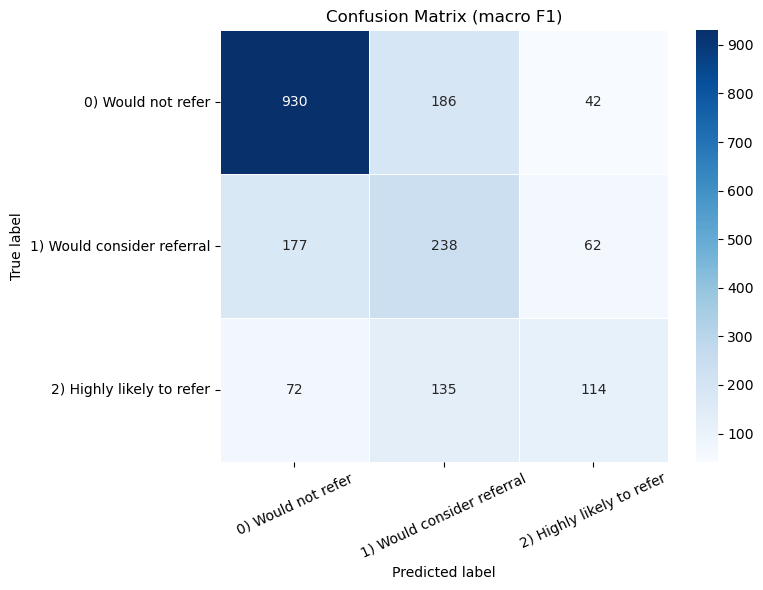


Best cutpoints for score 1 (Would consider): cut1=3, cut2=9, F1=0.4866
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.80      0.80      1158
1) Would consider referral       0.42      0.57      0.49       477
 2) Highly likely to refer       0.64      0.26      0.38       321

                  accuracy                           0.66      1956
                 macro avg       0.62      0.55      0.55      1956
              weighted avg       0.68      0.66      0.65      1956

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,930,208,20
1) Would consider referral,177,273,27
2) Highly likely to refer,72,164,85


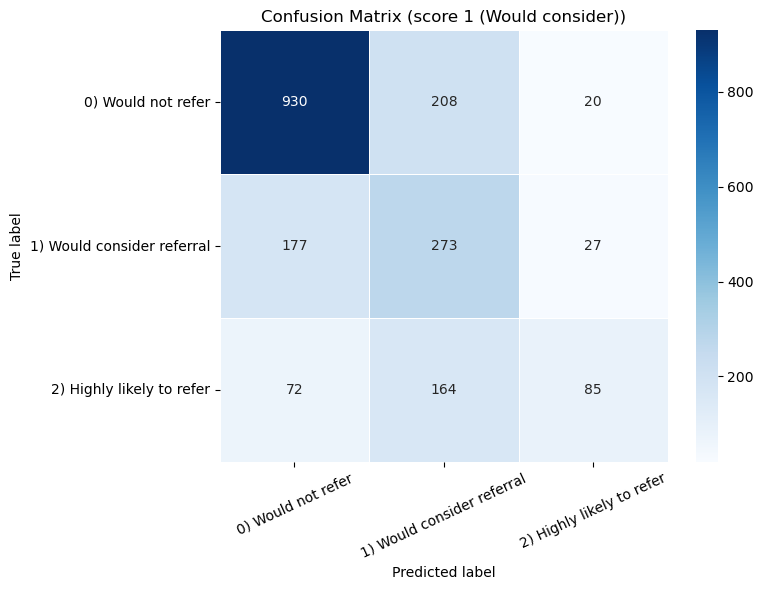


Best cutpoints for score 2 (Highly likely): cut1=1, cut2=5, F1=0.4628
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.72      0.75      1158
1) Would consider referral       0.18      0.06      0.09       477
 2) Highly likely to refer       0.33      0.77      0.46       321

                  accuracy                           0.56      1956
                 macro avg       0.43      0.51      0.43      1956
              weighted avg       0.56      0.56      0.54      1956

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,828,121,209
1) Would consider referral,161,29,287
2) Highly likely to refer,63,12,246


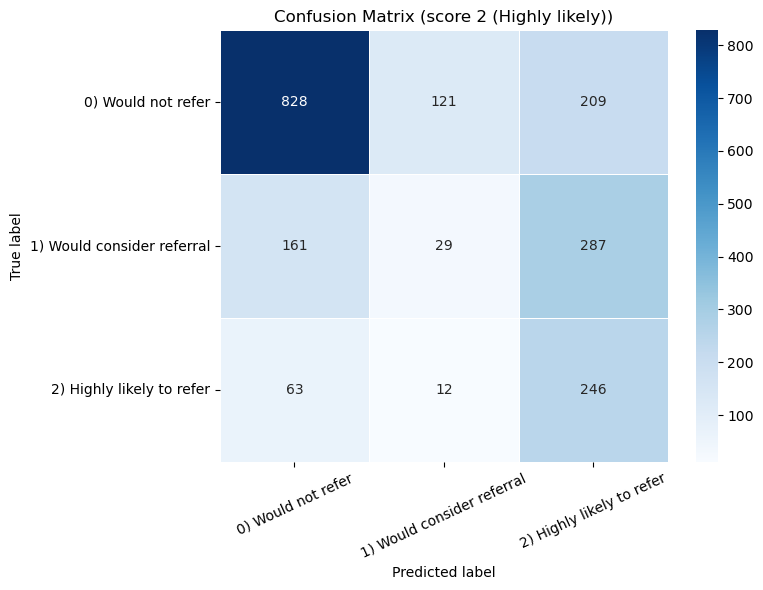

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

def display_results_with_plot(cut1, cut2, label, f1val):
    preds = np.digitize(score_y, bins=[cut1, cut2])
    print(f"\nBest cutpoints for {label}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    print(classification_report(
        score_x, preds, labels=[0, 1, 2],
        target_names=cut_labels
    ))
    cm = confusion_matrix(score_x, preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=cut_labels)
    print("Confusion Matrix:")
    display(cm_df)

    # Blue Confusion Matrix Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label})')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Show results and blue CM for each optimal cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)
display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)